# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')

import yfinance as yf
from tabulate import tabulate

Before providing the portfolios, we'll define a few useful functions that will be used for analysis:

In [2]:
# Concatenates the cumulative return to the portfolio dataframe

def cumulative_return_app(portfolio):

    if 'Cumulative Return' in portfolio:

        return portfolio
    
    close = portfolio['Close']

    cumulative_return = close/close.iloc[0] - 1
    
    cumulative_return.columns = pd.MultiIndex.from_product([['Cumulative Return'], cumulative_return.columns])

    return pd.concat([portfolio, cumulative_return], axis = 1)

# Concatenates the daily log return to the portfolio dataframe

def daily_return_app(portfolio):

    if 'Daily Log Return' in portfolio:

        return portfolio

    close = portfolio['Close']

    daily_return = np.log(close/close.shift(1))

    daily_return.columns = pd.MultiIndex.from_product([['Daily Log Return'], daily_return.columns])

    concat_df = pd.concat([portfolio, daily_return], axis = 1)

    return concat_df.dropna()

# The following function minimizes the quadratic form defined by the covariance matrix.

def min_q_form(portfolio, min_weight, max_weight):
    
    # A first approximation of minimizing weights

    uniform_weight = 1/len(portfolio['Close'].columns)

    uniform_weight_vec = np.array([uniform_weight]*len(portfolio['Close'].columns))

    # Constraint: sum of the weights is 1

    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
    ]

    bounds = [(min_weight, max_weight)] * len(uniform_weight_vec)

    # Define covariance matrix 

    cov_mat = 252*(daily_return_app(portfolio)['Daily Log Return'].cov())

    # Define the objective function

    obj_fun = lambda weights: np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))

    # Run the minimization

    return minimize(obj_fun, uniform_weight_vec, constraints=constraints, bounds=bounds)


# Low Risk Portfolio

To begin, we choose a large number of investments (with "large" being relative to the "risky" portfolio). The idea is simple: for a family of random variables $\{X_i\}_{i=1}^\infty$, we define the following random variable $$Z := \sum_{i=1}^{n} w_i X_i$$ where the weights satisfy $\sum_{i=1}^n w_i = 1$. Here, the random variable $Z$ represents the total return of the portfolio, with a proportion $w_i$ of total assets allocated to investment $X_i$. In general, the variance of the portfolio is given by $$\text{Var}(Z) = \sum_{i=1}^n w_i^2\text{Var}(X_i) + \sum_{i\neq j}^nw_iw_j\text{Cov}(X_i,X_j)
.$$ Thus, by choosing a large number of investments, the weights $w_i$ are smaller on average, and the overall variance of the portfolio tends to decrease. This, in turn, yields a safer (i.e. low volatility) investment.

The formula $\text{Var}(Z)$ reveals a few ways one could minimize the variance of Z.

## Minimization 1: Choosing Investments with Small Volatility

We first seek to minimize the variances of each individual investment. To this end, we'll screen for low volatility stocks using the following code. To save on search time, we'll assume the S&P 100 stocks will have sufficiently low volatility for a safe portfolio.


In [3]:
# The tickers in S&P 100

sp100_tickers = [
    'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT', 'AMZN',
    'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'BRK-B', 'C',
    'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS',
    'CVX', 'DE', 'DHR', 'DIS', 'DUK', 'EMR', 'FDX', 'GD', 'GE', 'GILD',
    'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG',
    'JNJ', 'JPM', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ',
    'MDT', 'MET', 'META', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX',
    'NKE', 'NOW', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PLTR', 'PM', 'PYPL',
    'QCOM', 'RTX', 'SBUX', 'SCHW', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS',
    'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC', 'WMT', 'XOM'
]

# Fetches historical data

stock_data = yf.download(sp100_tickers, start="2024-05-20", end="2025-05-21")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  101 of 101 completed


In [4]:
# Finds and concatenates the daily log returns to the data frame

stock_data = daily_return_app(stock_data)

# Calculates the annualized volatility and sorts

stock_volatility = stock_data['Daily Log Return'].std() * np.sqrt(252)

stock_volatility = stock_volatility.sort_values()

# Shows the lowest 10 annualized volatilities

stock_volatility.head(10)



Ticker
KO       0.170563
LIN      0.184177
DUK      0.184515
SO       0.191038
JNJ      0.193013
MO       0.193093
PG       0.193554
PEP      0.198087
BRK-B    0.198708
MCD      0.202691
dtype: float64

Given this data, it would be prudent to invest a subset of the following companies:

<div style="text-align:center">
{KO, LIN, DUK, SO, MO, JNJ, PG, PEP, BRK.B, MCD}
</div>

## Minimization 2: Choosing Investment with Small Covariance

Recall that the volatility of the portfolio $Z$ depends on the covariances between each pair of investments. To further minimize volatility, it would behoove us to construct a portfolio where these covariances are small.

[*********************100%***********************]  10 of 10 completed


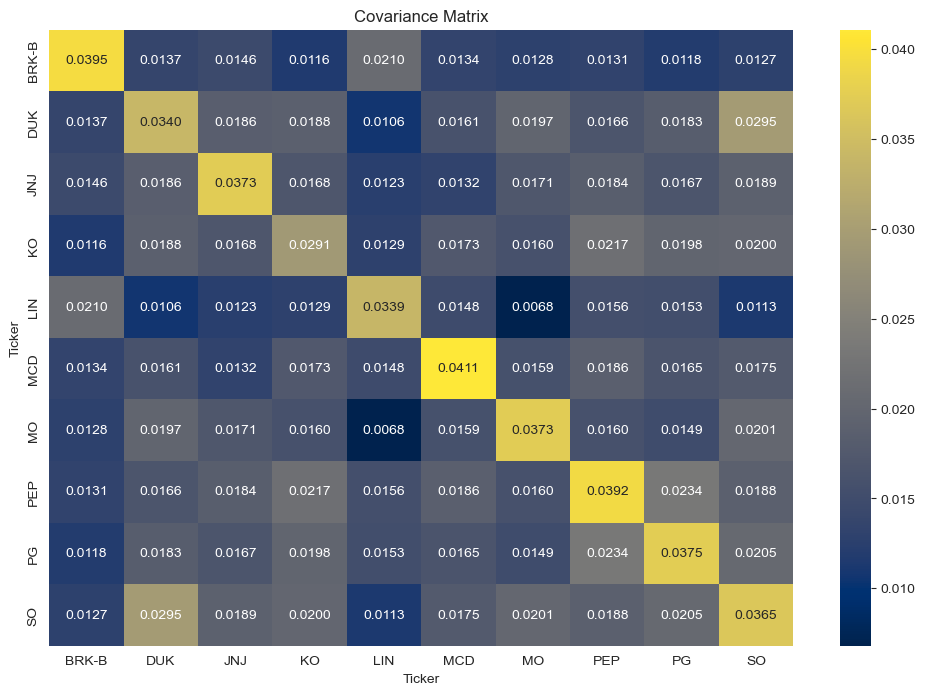

In [5]:
# The tickers for the prospective portfolio

port_tickers = ['KO', 'LIN', 'DUK', 'SO', 'MO','JNJ', 'PG', 'PEP', 'BRK-B', 'MCD']

# Fetches historical data

port_data = yf.download(port_tickers, start="2024-05-20", end="2025-05-21")

# Calculates the covariance matrix using the log daily returns

port_data = daily_return_app(port_data)

port_cov_mat = 252*(port_data['Daily Log Return'].cov())

# Plots a heatmap of the covariance matrix 

plt.figure(figsize = (12,8))
sns.heatmap(port_cov_mat, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

Since a covariance below 0.2 typically indicates strong diversification, and the highest off-diagonal covariance in our prospective portfolio is just 0.0296, we can conclude that the current selection of investments is sufficiently diverse to mitigate risk effectively.

## Minimization 3: Calculating Appropriate Weights

So far, we have minimized the volatility of each individual investment and ensured that the investments behave relatively independently of one another. The final optimization we can make to reduce overall volatility is to ensure that we weight our investments appropriately. To this end, denote by $\mathbf{w} = [w_1, \dots, w_n]^t$ the vector of portfolio weights and let $\mathbf{\Sigma}$ be the covariance matrix of the random vector $[X_1, X_2, \dots, X_n]$. Observe that $$\text{Var}(Z) = \mathbf{w}^t\mathbf{\Sigma}\mathbf{w}.$$ Thus, we may minimize the overall portfolio volatility by finding the vector $\mathbf{w}$ that minimizes this quadratic form.

In [6]:
min_data = min_q_form(port_data, -1, 1)

min_weights = min_data.x
min_vol = min_data.fun

print(f'The minimizing weights are: \n {min_weights} \n')
      
print(f'with minimum volatility of: \n {min_vol}.')


The minimizing weights are: 
 [ 0.10697506  0.10137989  0.10355424  0.16001434  0.22582363  0.0864289
  0.17046428  0.00067602  0.06791454 -0.02323089] 

with minimum volatility of: 
 0.13243409498568753.


Note: Weights less than 0 indicate short positions in the corresponding investments.


In [7]:
portfolio_low = pd.DataFrame({"Ticker": sorted(['KO', 'LIN', 'DUK', 'SO', 'MO','JNJ', 'PG', 'PEP', 'BRK-B', 'MCD']),
                          "Weight": min_data.x
                          })

portfolio_low.to_csv("Portfolio.tsv", sep = '\t', index = False)

print(tabulate(portfolio_low, headers='keys', tablefmt='pretty'))

+---+--------+-----------------------+
|   | Ticker |        Weight         |
+---+--------+-----------------------+
| 0 | BRK-B  |  0.10697506425872146  |
| 1 |  DUK   |  0.10137989292372697  |
| 2 |  JNJ   |  0.10355423907581442  |
| 3 |   KO   |  0.16001433646245927  |
| 4 |  LIN   |  0.2258236255733274   |
| 5 |  MCD   |  0.08642890194177733  |
| 6 |   MO   |  0.17046427697986036  |
| 7 |  PEP   | 0.0006760159885340734 |
| 8 |   PG   |  0.06791454177388681  |
| 9 |   SO   | -0.02323089497810826  |
+---+--------+-----------------------+


At first glance, this appears to be a reasonable solution to the optimization problem. However, we note that one of the investments is being shorted, an investment strategy widly accepted to be risky. We will conduct further tests to ensure that the proposed portfolio is both prudent and potentially profitable.

## Value at Risk

To ensure that our portfolio is not losing money on average, we will calculate the Value at Risk (VaR). While a direct calculation is straightforward, it relies on the assumption that log returns are normally distributed—a claim we will examine further in Project 2. For now, we will proceed with the calculation; however, a Monte Carlo simulation based on geometric Brownian motion will be conducted in a future project to more robustly evaluate the portfolio’s profitability.

The formula for Value at Risk is given by: $$\text{VaR} := z \cdot \sigma \cdot \sqrt{T}$$ where $z$ is the z-score corresponding to the chosen confidence level, $\sigma$ is the portfolio's volatility (standard deviation of returns), and $T$ is the number of days in the investment horizon.

In [8]:
z_score = 0.95
VaR = lambda z, vol, days: z*vol*np.sqrt(days)

print(f'The Value at Risk for our portfolio with z-score {z_score}, volatility {min_vol}, over {252} days is: {VaR(z_score, min_vol, 252)}')

The Value at Risk for our portfolio with z-score 0.95, volatility 0.13243409498568753, over 252 days is: 1.9972097784968013


Thus, assuming the log returns of our data are normally distributed, there is only a 5% chance that we will lose more than 2% of our investment.


## Low Risk Portfolio Overview

We now present our low-risk portfolio, along with the corresponding asset weights.

In [9]:
portfolio_low = pd.DataFrame({"Ticker": sorted(['KO', 'LIN', 'DUK', 'SO', 'MO','JNJ', 'PG', 'PEP', 'BRK-B', 'MCD']),
                          "Weight": min_data.x
                          })

portfolio_low.to_csv("Portfolio.tsv", sep = '\t', index = False)

print(tabulate(portfolio_low, headers='keys', tablefmt='pretty'))

+---+--------+-----------------------+
|   | Ticker |        Weight         |
+---+--------+-----------------------+
| 0 | BRK-B  |  0.10697506425872146  |
| 1 |  DUK   |  0.10137989292372697  |
| 2 |  JNJ   |  0.10355423907581442  |
| 3 |   KO   |  0.16001433646245927  |
| 4 |  LIN   |  0.2258236255733274   |
| 5 |  MCD   |  0.08642890194177733  |
| 6 |   MO   |  0.17046427697986036  |
| 7 |  PEP   | 0.0006760159885340734 |
| 8 |   PG   |  0.06791454177388681  |
| 9 |   SO   | -0.02323089497810826  |
+---+--------+-----------------------+


---

# High Risk Portfolio

For the high-risk portfolio, we aim to construct the most volatile portfolio possible. To do this, we begin with the same foundational logic used in constructing the low-risk portfolio and observe that maximizing volatility favors including as few assets as possible. With this in mind, we leverage the data from the low-risk analysis to scan the S&P 100 stocks for the most volatile constituents. You can probably guess which company tops the list.

In [10]:
# Uses the data from the first portion of the project to find the five most volatile companies

stock_volatility.tail()

Ticker
NVDA    0.600186
AVGO    0.622369
INTC    0.641086
PLTR    0.703889
TSLA    0.714994
dtype: float64

Thus, in our effort to construct the most volatile portfolio possible, we include only a single investment: Tesla. Notably, the more intuitive, conversational understanding of volatility also applies here — Tesla’s reputation for dramatic price swings amplifies the portfolio's overall risk by an indeterminate degree.

---

# Conclusion



In this project, we began by constructing a low-volatility portfolio, guided by the well-known heuristic that diversification reduces overall portfolio variance through the averaging of uncorrelated or weakly correlated risks. To implement this, we first calculated the annualized historical volatility (standard deviation of daily log returns scaled by ($\sqrt{252}$)) for each stock in the S&P 100. We then selected the 10 stocks with the lowest volatilities, prioritizing firms traditionally regarded as low-risk based on sector and market capitalization.

To further minimize portfolio risk, we examined the covariance matrix of the selected assets’ daily log returns and confirmed that the off-diagonal covariance terms were small, indicating low correlations between assets. This justified the diversification effect.

We then formulated the portfolio optimization problem as a quadratic programming problem, minimizing the portfolio variance defined by the covariance matrix $\Sigma$:

$$
\min_{w} \quad w^\top \Sigma w
$$

subject to natural constraints such as:

- Full investment: $\sum_i w_i = 1$
- Weight bounds: $-1 \leq w_i \leq 1$

Using numerical solvers (`scipy.optimize.minimize`), we computed the optimal asset weights that yielded the minimum variance portfolio. This resulted in a portfolio with a theoretically minimized volatility while remaining fully invested and realistic in terms of position sizes.

To assess downside risk, we calculated the portfolio’s Value at Risk (VaR) at a 95% confidence level, assuming (for the moment) normally distributed returns. The low VaR confirmed that the portfolio exhibited minimal expected loss under normal market conditions, making it plausibly profitable and relatively safe.

For the high-risk portfolio, our objective was to maximize volatility, effectively creating a “pure play” on risk. We selected a single stock, Tesla (TSLA), which our earlier empirical analysis identified as having the highest historical volatility and the heaviest distribution tails among the S&P 100 stocks. By focusing on this single highly volatile asset, we bypassed traditional portfolio optimization techniques, as the solution was trivial but effective—allocating 100% to Tesla maximized portfolio variance. This approach, while lacking mathematical complexity, served the purpose of creating an extreme-risk benchmark.

# Q&A

### Question:  If our goal was to minimize portfolio volatility, why didn’t we include bonds?

In the early stages of analysis, several bonds were included in the portfolio. However, incorporating them into the optimization led to extreme weight allocations—such as significant short positions—when minimizing the quadratic form defined by the covariance matrix. While this may have theoretically reduced volatility, the resulting portfolio was considered financially impractical and potentially unprofitable. As a result, we excluded bonds to ensure the portfolio remained both realistic and investable.

### Question: How do you know this portfolio is potentially profitable?

This question will be addressed in a future project (see Project X), where we will demonstrate that the expected return of the portfolio is positive. This will be done by simulating a range of possible future stock paths using geometric Brownian motion within a Monte Carlo framework.

### Question: Why not include the Sharpe Ratio in the analysis?

Calculating the Sharpe Ratio requires a reliable estimate of the expected returns. There are two common approaches to estimating this: using historical return data or simulating future stock paths. Since relying solely on historical data can be unreliable, and the geometric Brownian motion simulations will be developed in a future project, I have decided to defer this analysis to a later stage.

---